In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
galaxy_train_path = "C:/Users/Poll/Documents/ML project/Data/mdm/mdm_images/galaxy_postage/training"
galaxy_test_path = "C:/Users/Poll/Documents/ML project/Data/mdm/mdm_images/galaxy_postage/test"
star_train_path = "C:/Users/Poll/Documents/ML project/Data/mdm/mdm_images/star_postage/training"
star_test_path = "C:/Users/Poll/Documents/ML project/Data/mdm/mdm_images/star_postage/test"

In [6]:
"Use class Ridge from PS3 - open to try other types of linear regression but this is a first test"
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler # not used now

class Ridge(object):

    def __init__(self, alpha, normalize=False):
        """
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """

        self.alpha = alpha  # our tuning / regularization parameter
        self.coefficients = None  # our weights vector, w (in formulae above)
        self.intercept = None  # our intercept parameter, b (in formulae above)
        self.normalize = normalize  # boolean whether to normalize the features or not
        self.scaler = StandardScaler()  # method by which to normalize the features (depends on self.normalize)

    def fit(self, X, y):
        """
        Fit the ridge model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (num_samples, num_features)
        :param y: target values (num_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """
        num_nonzero_coefs, coef_norm = 0, 0
        
        # Normalize data with the scaler, if required
        if self.normalize:
            X = self.scaler.fit_transform(X)
        # Center the data
        X_center = X - np.mean(X, 0)
        w=np.linalg.inv(X_center.T@X_center+self.alpha*np.eye(X_center.shape[1]))@X_center.T@y
        self.coefficients=w
        element=np.argwhere(w!=0)
        num_nonzero_coefs=len(element)
        coef_norm=np.linalg.norm(w)
        self.intercept=np.zeros(len(y))
        b_store=[]
        N=X.shape[0]
        for i in range(X.shape[0]):
            b=(y[i]-w.T@X[i,:])
            b_store.append(b)
        b_sum=np.sum(b_store)/N
        self.intercept=b_sum
        return num_nonzero_coefs, coef_norm

    def evaluate(self, X, y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values of the test data
        :param X: instances array of shape (num_samples, num_features)
        :param y: the true targets, of shape (num_samples)
        :return: RMSE
        """
        if self.normalize:
            X = self.scaler.transform(X)
        # Center the data
        #X_center = X - np.mean(X, 0)
        summation=0
        for i in range(X.shape[0]):
            y_hat=self.coefficients.T@X[i]+self.intercept #w.T*X+b
            summation+=((y[i]-y_hat)**2)
        root_mean_squared_error=np.sqrt(summation/X.shape[0])#np.sqrt(np.mean(y_square)) 
        return root_mean_squared_error

In [8]:
"Adding features blurring, pixelation and noise"

def load_data(data_path):
    data = []
    for filename in os.listdir(data_path):
        if filename.endswith(".png"):
            img = cv2.imread(os.path.join(data_path, filename), cv2.IMREAD_GRAYSCALE)
            data.append(img.flatten()) # flatten 2D matrix into 1D array
    return np.array(data)
# load data
galaxy_train_data = load_data(galaxy_train_path)
galaxy_test_data = load_data(galaxy_test_path)
star_train_data = load_data(star_train_path)
star_test_data = load_data(star_test_path)

In [ ]:
# Add blurring, pixelation, and noise features
#def add_features(data):
#    features = []
#    for i in range(len(data)):
#        # reshape to 36x64
#        b = data.reshape(9600, 9600)
#        img=b
#        # crop center part to get 32x32
#        #c = b[2:34, 16:48]
#        #img = c[i].reshape(16, 16) # resize to a smaller image to prevent overfitting (original is 48x48 pixels)
#        # Add blurring feature
#        blur = cv2.GaussianBlur(img, (5, 5), 0) # chosen kernel size 5x5 pixels
#        blur_feature = blur.flatten()
#        # Add pixelation feature
#        resized = cv2.resize(img, (10, 10), interpolation=cv2.INTER_NEAREST) # chosen kernel size 10x10 pixels
#        pixel_feature = resized.flatten()
#        # Add noise feature
#        noise = np.random.normal(0, 1, img.shape)
#        noisy_img = img + noise
#        noisy_img[noisy_img < 0] = 0 # min
#        noisy_img[noisy_img > 255] = 255 # max
#        noise_feature = noisy_img.flatten()
#        # Combine all features
#        features.append(np.concatenate([data[i], blur_feature, pixel_feature, noise_feature]))
#    return np.array(features)

In [9]:
#galaxy_train_data = add_features(galaxy_train_data)
#galaxy_test_data = add_features(galaxy_test_data)
#star_train_data = add_features(star_train_data)
#star_test_data = add_features(star_test_data)

X_train = np.concatenate([galaxy_train_data, star_train_data])
# Assign binary labels to the data points in the training set. 
# Assign label 1 to a galaxy image (array of ones) 
# and label 0 to a star image (array of zeros)
y_train = np.concatenate([np.ones(len(galaxy_train_data)), np.zeros(len(star_train_data))])
X_test = np.concatenate([galaxy_test_data, star_test_data])
y_test = np.concatenate([np.ones(len(galaxy_test_data)), np.zeros(len(star_test_data))])

In [13]:
"Plot the things as in PS3 - not working yet since code above takes a long time"
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 1.0, 10.0, 100.0, 300.0, 500.0, 1e3, 1.5e3, 2e3, 5e3, 1e4]
coef_norm_stored=[]
num_nonzero_coefs_stored=[]
rmse_stored=[]
coef_norm_stored_normalized=[]
num_nonzero_coefs_stored_normalized=[]
rmse_stored_normalized=[]
for a in alphas:
    
    ridge= Ridge(a, normalize=False)
    num_nonzero_coefs, coef_norm=ridge.fit(X_train, y_train)
    coef_norm_stored.append(coef_norm)
    num_nonzero_coefs_stored.append(num_nonzero_coefs)
    root_mean_squared_error=ridge.evaluate(X_test, y_test)
    rmse_stored.append(root_mean_squared_error)

NameError: name 'plt' is not defined

C:\Users\Poll\AppData\Local\Temp\ipykernel_10164\3224352535.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


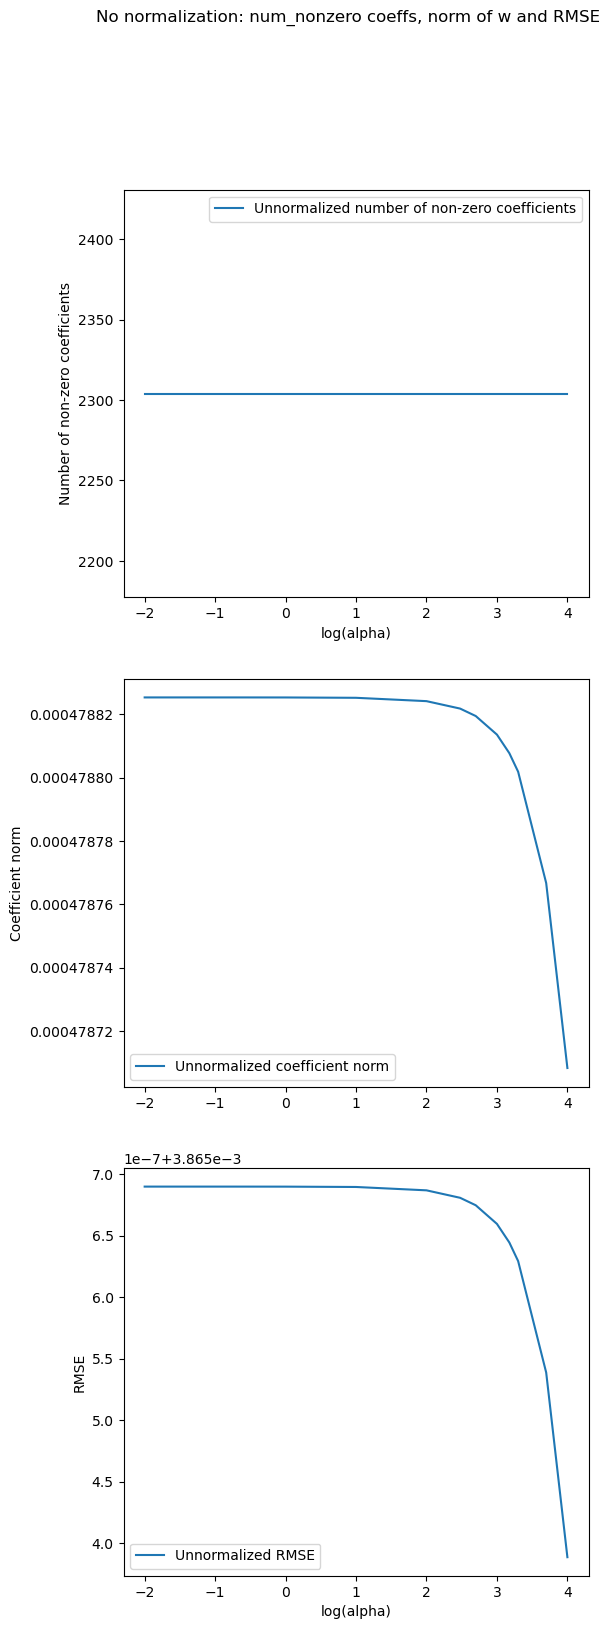

In [15]:
fig, axs = plt.subplots(3)
fig.set_figheight(18)
fig.set_figwidth(6)
fig.suptitle('No normalization: num_nonzero coeffs, norm of w and RMSE')
axs[0].plot(np.log10(alphas), num_nonzero_coefs_stored, label="Unnormalized number of non-zero coefficients")
axs[0].set_xlabel("log(alpha)")
axs[0].set_ylabel("Number of non-zero coefficients")
axs[0].legend()
axs[1].plot(np.log10(alphas), coef_norm_stored, label="Unnormalized coefficient norm")
axs[1].set_ylabel("Coefficient norm")
axs[1].legend()
axs[2].plot(np.log10(alphas), rmse_stored, label="Unnormalized RMSE")
axs[2].set_xlabel("log(alpha)")
axs[2].set_ylabel("RMSE")
axs[2].legend()
fig.show()

In [18]:
"Run Ridge class"
classifier = Ridge(alpha=0.1)
classifier.fit(X_train, y_train)

train_accuracy = classifier.evaluate(X_train, y_train)
test_accuracy = classifier.evaluate(X_test, y_test)

print("Training RMSE:", train_accuracy)
print("Test RMSE:", test_accuracy)

Training RMSE: 0.0038258543233845943
Test RMSE: 0.0038656897795265825


In [17]:
print(rmse_stored)

[0.003865689782255265, 0.0038656897810400177, 0.0038656897795265825, 0.003865689776486958, 0.0038656897734863907, 0.0038656897522405574, 0.0038656894793511437, 0.003865686750556572, 0.0038656806877408207, 0.0038656746265799532, 0.0038656594807980043, 0.0038656443452248558, 0.0038656292198558503, 0.0038655386812853068, 0.0038653885950691597]
